![](https://assets-global.website-files.com/5d7b77b063a9066d83e1209c/61e9d06c613399dc20011575_6NGq2uP-p-1600.png)

<center><h1> 🔎 DoppelVision: Finding the image twin </h1></center>

🌥️ Ever glanced at a cloud and saw a face? Or spotted a familiar figure in your morning toast? This phenomenon, known as pareidolia, is a fascinating quirk of the human brain, where we often see faces or familiar patterns in unrelated objects.

It's this intrinsic human tendency to see familiar patterns in seemingly unrelated objects that raises an intriguing question: **Can we train machines to emulate this uniquely human trait?**

🤖 Deep learning has made impressive advancements, but the real challenge lies in getting machines to match human perception in assessing image likeness.

### Finding the right dataset
To embark on this quest, the first step was selecting the right dataset. [The Totally-Looks-Like dataset](https://www.kaggle.com/datasets/ruchi798/totally-looks-like-dataset) emerged as an ideal choice. It's a curated collection that pairs images based on perceived similarity by humans, providing a foundation for training models to see images as we do.

### Siamese Networks & Transfer Learning
- With the dataset in place, the next phase was model selection and training. I chose to implement Siamese Networks, known for their prowess in discerning similarities, to mirror human-like image recognition. Furthermore, to optimize performance,
- I used ResNet-50 as the backbone, to extract features from images and thereby improving the model's ability to gauge image similarities

### Efficient Training & Scalability
To handle the scale of the data scale and the complexity of the model complexity, I turned to Hugging Face's Accelerate. Paired with the Z by HP Z8 Fury, this approach ensured efficient multi-GPU training, drastically reducing training times and improving scalability.

In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import random
import cv2

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision

from torchvision import transforms
from torch.utils.data import DataLoader, Dataset, SubsetRandomSampler, random_split
from torchvision.transforms import Compose, Resize, ToTensor, Normalize
from torch.nn import SyncBatchNorm
from torchvision.models import resnet50
from torchvision.io import read_image
from torchvision.transforms import ToPILImage
from PIL import Image
from accelerate import Accelerator
from accelerate import notebook_launcher

import warnings
warnings.filterwarnings("ignore")

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
Config = {
'TARGET_SHAPE' : (200, 200),
'NUM_EPOCHS' : 10,
'MARGIN': 0.5, 
'LR' : 1e-4
}

In [3]:
def set_seed(seed_value=12):
    """Set seed for reproducibility."""
    torch.manual_seed(seed_value)
    torch.cuda.manual_seed(seed_value)
    torch.cuda.manual_seed_all(seed_value)  # if using multi-GPU
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    np.random.seed(seed_value)

set_seed()

In [4]:
def getImagePaths(path):
    image_names = []
    for dirname, _, filenames in os.walk(path):
        for filename in filenames:
            fullpath = os.path.join(dirname, filename)
            image_names.append(fullpath)
    return image_names

left_dir_path = "/kaggle/input/totally-looks-like-dataset/left/left"
right_dir_path = "/kaggle/input/totally-looks-like-dataset/right/right"

left_images_path = getImagePaths(left_dir_path)
right_images_path = getImagePaths(right_dir_path)

print(f"Number of left images: {len(left_images_path)}\n")
print(f"Number of right images: {len(right_images_path)}\n")

Number of left images: 6016

Number of right images: 6016



In [5]:
def getShape(images_paths):
    shape = cv2.imread(images_paths[0]).shape
    for image_path in images_paths:
        image_shape=cv2.imread(image_path).shape
        if (image_shape!=shape):
            return "Different image shape"
        else:
            return "Same image shape " + str(shape)

In [6]:
getShape(left_images_path)

'Same image shape (245, 200, 3)'

In [7]:
getShape(right_images_path)

'Same image shape (245, 200, 3)'

In [8]:
# Sort the list based on the image file names
anchor_images = sorted(left_images_path, key=lambda x: x.split('/')[-1])
positive_images = sorted(right_images_path, key=lambda x: x.split('/')[-1])

In [9]:
def preprocess_image(image_tensor):
    """
    Preprocess the input image tensor.
    """
    
    # Define the transformations
    transform = transforms.Compose([
    transforms.Resize(Config['TARGET_SHAPE'], antialias=True),  # Explicitly set antialias to True
    ])
    
    # Apply the transformations
    image = transform(image_tensor)
    
    return image

def preprocess_triplets(anchor, positive, negative):
    """
    Given the filenames corresponding to the three images, load and
    preprocess them.
    """
    return (
        preprocess_image(anchor),
        preprocess_image(positive),
        preprocess_image(negative),
    )


In [10]:
class TLLDataset(Dataset):
    def __init__(self, anchor_image_paths, positive_image_paths):
        
        # Load images and convert to tensors
        anchor_images = [read_image(path) for path in anchor_image_paths]
        positive_images = [read_image(path) for path in positive_image_paths]
        
        # Shuffle anchor and positive images to get negative images
        negative_images = anchor_images + positive_images
        random.shuffle(negative_images)
        
        self.anchor_images = torch.stack(anchor_images)
        self.positive_images = torch.stack(positive_images)
        self.negative_images = torch.stack(negative_images)
        
    def __len__(self):
        return len(self.anchor_images)
    
    def __getitem__(self, idx):
        anchor = self.anchor_images[idx]
        positive = self.positive_images[idx]
        negative = self.negative_images[idx]
        
        anchor, positive, negative = preprocess_triplets(anchor, positive, negative)
        
        return anchor, positive, negative

# Create an instance of TLLDataset
tll_dataset = TLLDataset(anchor_images, positive_images)

# Determine the indices for training, validation, and testing
image_count = len(tll_dataset)
indices = list(range(image_count))

# Define split points
train_split = round(image_count * 0.8)
val_split = train_split + round(image_count * 0.1)

train_indices = indices[:train_split]
val_indices = indices[train_split:val_split]
test_indices = indices[val_split:]

# Create SubsetRandomSamplers
train_sampler = SubsetRandomSampler(train_indices)
val_sampler = SubsetRandomSampler(val_indices)
test_sampler = SubsetRandomSampler(test_indices)

# Create DataLoaders for training, validation, and testing
train_loader = DataLoader(tll_dataset, batch_size=16, sampler=train_sampler, num_workers=8, drop_last=True)
val_loader = DataLoader(tll_dataset, batch_size=16, sampler=val_sampler, num_workers=8, drop_last=True)
test_loader = DataLoader(tll_dataset, batch_size=16, sampler=test_sampler, num_workers=8, drop_last=True)

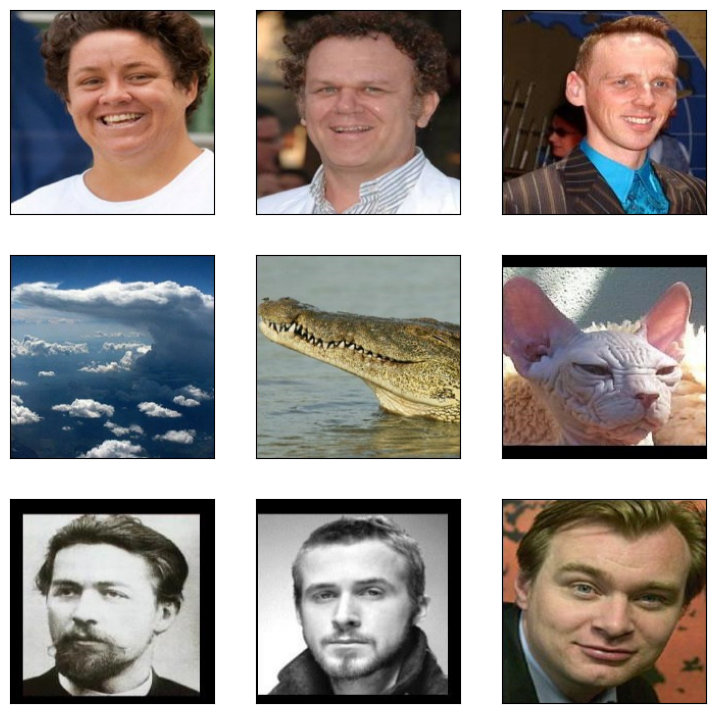

In [11]:
def visualize(anchor, positive, negative):
    """Visualize a few triplets from the supplied batches."""
    
    def show(ax, image_tensor):
        # Define a transform to convert a tensor to PIL image
        transform = transforms.ToPILImage()
        # Convert the tensor to PIL image using the above transform
        img = transform(image_tensor)
        
        ax.imshow(img)
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

    fig, axs = plt.subplots(3, 3, figsize=(9, 9))

    for i in range(3):
        show(axs[i, 0], anchor[i])
        show(axs[i, 1], positive[i])
        show(axs[i, 2], negative[i])

# Get one batch of data
for anchor, positive, negative in train_loader:
    visualize(anchor, positive, negative)
    break  # visualize only one batch

In [12]:
class EmbeddingNet(nn.Module):
    def __init__(self):
        
        super(EmbeddingNet, self).__init__()
        
        # Load a pre-trained ResNet50 model
        resnet = resnet50()
        
        # Freeze all layers except the last Convolution block
        for name, param in resnet.named_parameters():
            if "layer4" not in name:
                param.requires_grad = False
                
        # Define the embedding network by adding a few dense layers
        self.features = nn.Sequential(*list(resnet.children())[:-1])  # Exclude the last FC layer
        self.flatten = nn.Flatten()
        self.dense1 = nn.Sequential(nn.Linear(2048, 512), nn.ReLU(), SyncBatchNorm(512))
        self.dense2 = nn.Sequential(nn.Linear(512, 256), nn.ReLU(), SyncBatchNorm(256))
        self.output = nn.Linear(256, 256)
        
    def forward(self, x):
        x = self.features(x)
        x = self.flatten(x)
        x = self.dense1(x)
        x = self.dense2(x)
        x = self.output(x)
        return x

In [13]:
class DistanceLayer(nn.Module):
    def __init__(self):
        super(DistanceLayer, self).__init__()

    def forward(self, anchor, positive, negative):
        ap_distance = F.pairwise_distance(anchor, positive, 2)
        an_distance = F.pairwise_distance(anchor, negative, 2)
        return ap_distance, an_distance

class TripletMarginLoss(nn.Module):
    def __init__(self, margin):
        super(TripletMarginLoss, self).__init__()
        self.margin = margin

    def forward(self, ap_distance, an_distance):
        return F.relu(ap_distance - an_distance + self.margin).mean()
    
class SiameseNetwork(nn.Module):
    def __init__(self, embedding_net):
        super(SiameseNetwork, self).__init__()
        self.embedding_net = embedding_net
        self.distance_layer = DistanceLayer()
        
    def forward(self, anchor, positive, negative):
        anchor_embedding = self.embedding_net(anchor)
        positive_embedding = self.embedding_net(positive)
        negative_embedding = self.embedding_net(negative)
        ap_distance, an_distance = self.distance_layer(anchor_embedding, positive_embedding, negative_embedding)
        return ap_distance, an_distance

In [14]:
def fit(model, optimizer, train_loader, val_loader, num_epochs, margin, device, accelerator):
    # Define the triplet loss criterion
    criterion = TripletMarginLoss(margin)
    
    for epoch in range(num_epochs):
        accelerator.print(f"{'='*20} Epoch: {epoch+1} {'='*20}\n")
        
        # Training
        model.train()
        train_loss = 0.0
        for idx, (anchor, positive, negative) in enumerate(train_loader):
            optimizer.zero_grad()
            
            anchor = anchor.to(device, dtype=torch.float)
            positive = positive.to(device, dtype=torch.float)
            negative = negative.to(device, dtype=torch.float)
            ap_distance, an_distance = model(anchor, positive, negative)
            loss = criterion(ap_distance, an_distance)
            
            accelerator.backward(loss)
            optimizer.step()
            
            train_loss += loss.item()
            if idx % 100 == 0:  # Print after every 100 batches
                accelerator.print(f"Epoch: {epoch+1}/{num_epochs}, Batch: {idx}, Training Loss: {loss.item():.4f}")
        
        avg_train_loss = train_loss / len(train_loader)
        accelerator.print(f"\nEpoch: {epoch+1} / {num_epochs}  |  Average Training Loss: {avg_train_loss:.4f}\n")
        
        # Validation
        model.eval()
        val_loss = 0.0
        with torch.no_grad():
            for idx, (anchor, positive, negative) in enumerate(val_loader):
                anchor = anchor.to(device, dtype=torch.float)
                positive = positive.to(device, dtype=torch.float)
                negative = negative.to(device, dtype=torch.float)
                ap_distance, an_distance = model(anchor, positive, negative)
                loss = criterion(ap_distance, an_distance)
                
                val_loss += loss.item()
                if idx % 10 == 0:  # Print after every 10 batches
                    accelerator.print(f"Epoch: {epoch+1}/{num_epochs}, Batch: {idx}, Validation Loss: {loss.item():.4f}")
        
        avg_val_loss = val_loss / len(val_loader)
        accelerator.print(f"\nEpoch: {epoch+1} / {num_epochs}  |  Average Validation Loss: {avg_val_loss:.4f}\n")
        
        # Save the model 
        accelerator.wait_for_everyone() 
        model = accelerator.unwrap_model(model)
        model_path = f"epoch_{epoch+1}_model.pth"
        accelerator.save(model, model_path)

In [15]:
def training_loop(train_loader, val_loader, Config):
    accelerator = Accelerator()
    device = accelerator.device
    
    embedding_net = EmbeddingNet()
    model = SiameseNetwork(embedding_net)
    model = model.to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=Config['LR'])

    model, optimizer, train_dataloader, val_loader = accelerator.prepare(
        model, optimizer, train_loader, val_loader
    )

    # Start training
    fit(
            model = model, 
            optimizer = optimizer, 
            train_loader = train_loader, 
            val_loader = val_loader, 
            num_epochs = Config['NUM_EPOCHS'],
            margin = Config['MARGIN'], 
            device = device, 
            accelerator = accelerator, 
        )

In [16]:
args = (train_loader, val_loader, Config)
notebook_launcher(training_loop, args, num_processes=2)

Launching training on 2 GPUs.
==================== Epoch: 1 ====================

Epoch: 1/10, Batch: 0, Training Loss: 1.2332
Epoch: 1/10, Batch: 100, Training Loss: 0.7466
Epoch: 1/10, Batch: 200, Training Loss: 0.8713

Epoch: 1 / 10  |  Average Training Loss: 0.9074

Epoch: 1/10, Batch: 0, Validation Loss: 0.9582
Epoch: 1/10, Batch: 10, Validation Loss: 1.0872

Epoch: 1 / 10  |  Average Validation Loss: 0.9222

==================== Epoch: 2 ====================

Epoch: 2/10, Batch: 0, Training Loss: 1.5216
Epoch: 2/10, Batch: 100, Training Loss: 0.7283
Epoch: 2/10, Batch: 200, Training Loss: 0.3146

Epoch: 2 / 10  |  Average Training Loss: 0.6682

Epoch: 2/10, Batch: 0, Validation Loss: 0.5286
Epoch: 2/10, Batch: 10, Validation Loss: 0.4565

Epoch: 2 / 10  |  Average Validation Loss: 0.8111

==================== Epoch: 3 ====================

Epoch: 3/10, Batch: 0, Training Loss: 0.4768
Epoch: 3/10, Batch: 100, Training Loss: 0.6984
Epoch: 3/10, Batch: 200, Training Loss: 0.5059

Ep

In [17]:
def compute_similarity(model, anchor, positive, negative):    
    with torch.no_grad():
        anchor_embedding = model(anchor).squeeze(0).view(-1)
        positive_embedding = model(positive).squeeze(0).view(-1)
        negative_embedding = model(negative).squeeze(0).view(-1)

    positive_similarity = F.cosine_similarity(anchor_embedding.unsqueeze(0), positive_embedding.unsqueeze(0))
    negative_similarity = F.cosine_similarity(anchor_embedding.unsqueeze(0), negative_embedding.unsqueeze(0))
    
    return positive_similarity.item(), negative_similarity.item()

In [18]:
def inference_loop(model, device, anchor, positive, negative, is_pretrained=True):
    # Ensure the input tensors are on the correct device
    anchor = anchor.to(device, dtype=torch.float)
    positive = positive.to(device, dtype=torch.float)
    negative = negative.to(device, dtype=torch.float)
    
    model = model.to(device)
    model.eval()  # Set the model to evaluation mode

    pos_sim, neg_sim = compute_similarity(model, anchor, positive, negative)
    
    model_type = "Pretrained Model" if is_pretrained else "Fine-tuned Model"
    
    print(f"\nFor {model_type}:")
    print("Positive similarity:", pos_sim)
    print("Negative similarity:", neg_sim)


For Pretrained Model:
Positive similarity: 0.9687967300415039
Negative similarity: 0.9363538026809692

For Fine-tuned Model:
Positive similarity: 0.2613043487071991
Negative similarity: 0.12801985442638397


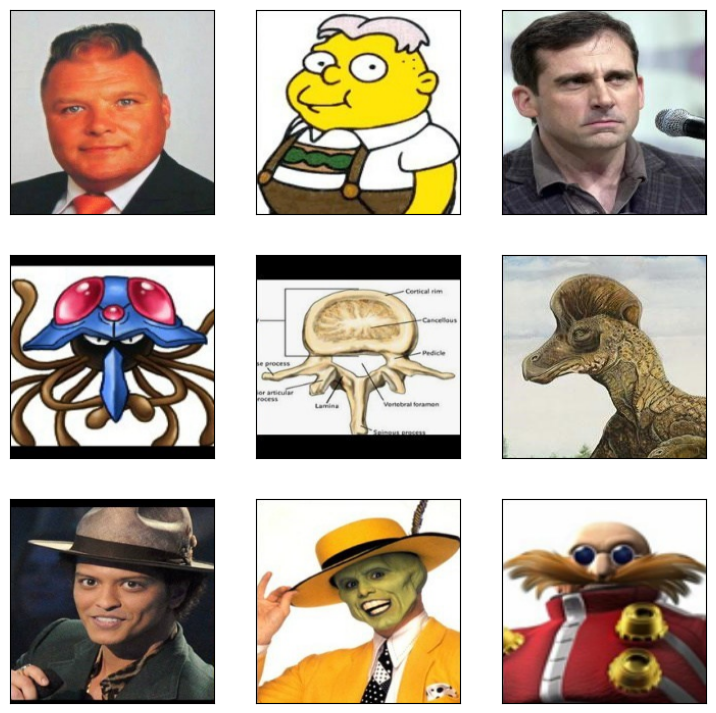

In [19]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Extract a batch from the test_loader
anchor, positive, negative = next(iter(test_loader))
visualize(anchor, positive, negative)

# For pretrained model
# Load the pretrained ResNet model
resnet_model = resnet50()
# Remove the classification head to get embeddings
embedding_resnet = nn.Sequential(*list(resnet_model.children())[:-1])
inference_loop(embedding_resnet, device, anchor, positive, negative, is_pretrained=True)

# For fine-tuned model
model = torch.load("epoch_10_model.pth")
embedding_finetuned = model.embedding_net
inference_loop(embedding_finetuned, device, anchor, positive, negative, is_pretrained=False)

### Pretrained Model Results:

The pretrained model was trained on a large dataset (likely ImageNet) to recognize a wide range of classes. When you use it as a feature extractor (embedding generator), it provides embeddings that capture generic visual features. This is evident from the results:
- The positive pair, which should be similar, has a high cosine similarity.
- The negative pair, which should be dissimilar, also has a relatively high cosine similarity. This indicates that the embeddings from the pretrained model might not be discriminative enough for your specific task.

### Fine-tuned Model Results:

The fine-tuned model has been trained specifically for the task of differentiating between the anchor and positive/negative pairs. The results are more aligned with what one would expect:
- The positive pair has a higher cosine similarity than the negative pair, which is the desired outcome.